<a href="https://colab.research.google.com/github/badabad/DS-Unit-2-Linear-Models/blob/master/Copy_of_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [118]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*
    

# If you're working locally:
else:
    DATA_PATH = '../data/'

!pip install category_encoders==2.*
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

## Import

In [119]:
import pandas as pd
import pandas_profiling
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest

In [120]:
# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [121]:
#df.profile_report()

In [122]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [123]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [124]:
df = df[(df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS') &
        (df['SALE_PRICE'] > 100000) &
        (df['SALE_PRICE'] < 2000000)]
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])
df.set_index('SALE_DATE', inplace=True)

In [125]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
SALE_DATE,,,,,,,,,,,,,,,,,,,,
2019-01-01,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000
2019-01-01,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000
2019-01-02,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000
2019-01-02,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000
2019-01-02,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000


In [126]:
df.isnull()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
SALE_DATE,,,,,,,,,,,,,,,,,,,,
2019-01-01,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
2019-01-01,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
2019-01-02,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
2019-01-02,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
2019-01-02,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-30,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
2019-04-30,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
2019-04-30,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False


In [127]:
df.isnull().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         3151
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  3150
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
dtype: int64

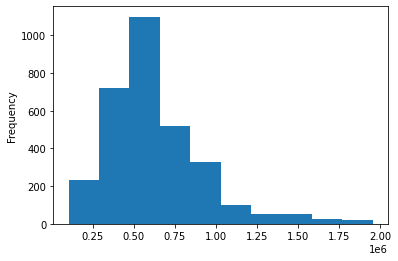

In [128]:
df['SALE_PRICE'].plot.hist()

## Split data into train and test data

In [129]:
target = 'SALE_PRICE'
X = df.drop([target] + ['EASE-MENT', 'APARTMENT_NUMBER'], axis=1)
y=df[target]

cut_off = '2019-04-01'
mask = X.index<cut_off

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

In [130]:
# Instantiate transformer - one hot encoder
transformer = OneHotEncoder(use_cat_names=True)

# Transform to fit training data
transformer.fit(X_train)

# Transform our training data
XT_train = transformer.transform(X_train)

In [131]:
XT_train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ADDRESS_4832 BAY PARKWAY,ADDRESS_80-23 232ND STREET,ADDRESS_1260 RHINELANDER AVE,ADDRESS_469 E 25TH ST,ADDRESS_5521 WHITTY LANE,ADDRESS_1747 EAST 23RD STREET,ADDRESS_1582 EAST 15TH STREET,ADDRESS_201-08 50TH AVENUE,ADDRESS_85-11 57 ROAD,ADDRESS_53-19 198TH STREET,...,"LAND_SQUARE_FEET_5,425","LAND_SQUARE_FEET_1,767","LAND_SQUARE_FEET_1,293","LAND_SQUARE_FEET_2,708","LAND_SQUARE_FEET_2,233","LAND_SQUARE_FEET_2,260","LAND_SQUARE_FEET_5,005","LAND_SQUARE_FEET_1,235","LAND_SQUARE_FEET_4,298","LAND_SQUARE_FEET_1,060",LAND_SQUARE_FEET_946,"LAND_SQUARE_FEET_1,698","LAND_SQUARE_FEET_3,990","LAND_SQUARE_FEET_3,012","LAND_SQUARE_FEET_2,231","LAND_SQUARE_FEET_4,485","LAND_SQUARE_FEET_1,918","LAND_SQUARE_FEET_2,020","LAND_SQUARE_FEET_1,380","LAND_SQUARE_FEET_3,338","LAND_SQUARE_FEET_3,692","LAND_SQUARE_FEET_2,755","LAND_SQUARE_FEET_3,230","LAND_SQUARE_FEET_2,121","LAND_SQUARE_FEET_4,361","LAND_SQUARE_FEET_3,910",GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
SALE_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
2019-01-01,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0
2019-01-02,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
2019-01-02,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0
2019-01-02,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0


## Holy shit! 3431 columns
Gonna need to bring that down to a more reasonable number, but first Imma test our metrics

In [132]:
# Ridge regression
# Instantiate
model = Ridge(normalize=True)

# Fit to training data
model.fit(XT_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [133]:
y_pred = model.predict(XT_train)
print('Training MAE:', mean_absolute_error(y_train, y_pred))
print('Training R2:', r2_score(y_train,y_pred))

XT_val = transformer.transform(X_val)
y_pred2 = model.predict(XT_val)
print('Validation MAE:', mean_absolute_error(y_val, y_pred2))
print('Validation R2:', r2_score(y_val, y_pred2))

Training MAE: 79162.43068559871
Training R2: 0.8594450377013636
Validation MAE: 181757.4770912282
Validation R2: 0.22649067202765416


#Time to trim off some of those unneccessary columns without destroying my r2 score

In [134]:
# SelectKBest
# Instantiate transformer
transformer_2 = SelectKBest(k=2000)

# Fit transformer to training data
transformer_2.fit(XT_train, y_train)

# Transform training data
XTT_train = transformer_2.transform(XT_train)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [   4   12   28   29   36   37   42   51   60   72   77   81   83   84
   85   91   92  104  111  112  114  121  125  130  131  144  150  153
  164  175  176  177  179  184  186  189  197  206  208  215  224  230
  232  247  250  253  255  261  262  263  266  278  282  299  310  313
  314  326  329  337  347  350  354  360  363  365  369  377  378  381
  382  385  386  387  389  390  399  408  411  412  415  416  429  431
  433  437  441  442  448  452  457  461  477  478  483  490  491  497
  506  510  514  518  519  522  526  530  531  534  535  536  545  550
  559  562  564  567  572  588  592  595  597  599  603  604  607  614
  616  622  624  625  631  636  638  639  640  642  643  644  646  649
  651  653  658  660  667  668  674  682  687  688  692  694  696  697
  700  707  710  712  714  722  725  729  730  739  751  753  754  767
  777  781  782  783  785  788 

In [135]:
#Ridge regression again
# Instantiate
model_2 = Ridge(normalize=True)

# Fit to training data
model_2.fit(XTT_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [136]:
y_pred = model_2.predict(XTT_train)

print('Training MAE:', mean_absolute_error(y_train, y_pred))
print('Training R2:', r2_score(y_train,y_pred))

Training MAE: 104072.35611200167
Training R2: 0.7743752964558342


## Even with selectKBest at 2000 I still have a significant decrease in R2 score. I originally tried k=100 which brought my R2 extremely low

I'm going to try trimming some of the original columns off and see if that changes anything

In [137]:
df = df[(df['RESIDENTIAL_UNITS'] >= np.percentile(df['RESIDENTIAL_UNITS'], 0.5)) & 
        (df['RESIDENTIAL_UNITS'] <= np.percentile(df['RESIDENTIAL_UNITS'], 99.5)) & 
        (df['GROSS_SQUARE_FEET'] >= np.percentile(df['GROSS_SQUARE_FEET'], 0.05)) & 
        (df['GROSS_SQUARE_FEET'] < np.percentile(df['GROSS_SQUARE_FEET'], 99.95)) &
        (df['COMMERCIAL_UNITS'] >= np.percentile(df['COMMERCIAL_UNITS'], 0.05)) &
        (df['COMMERCIAL_UNITS'] < np.percentile(df['COMMERCIAL_UNITS'], 99.95)) &
        (df['TOTAL_UNITS'] >= np.percentile(df['TOTAL_UNITS'], 0.05)) &
        (df['TOTAL_UNITS'] < np.percentile(df['TOTAL_UNITS'], 99.95)) &
        (df['SALE_PRICE'] >= np.percentile(df['SALE_PRICE'], 0.05)) &
        (df['SALE_PRICE'] < np.percentile(df['SALE_PRICE'], 99.95)) &
        (df['RESIDENTIAL_UNITS'] >= np.percentile(df['RESIDENTIAL_UNITS'], 0.05)) & 
        (df['RESIDENTIAL_UNITS'] <= np.percentile(df['RESIDENTIAL_UNITS'], 99.95))]

In [138]:
target = 'SALE_PRICE'
X = df.drop([target] + ['EASE-MENT', 'APARTMENT_NUMBER', 'BOROUGH', 'BLOCK', 'LOT', 'ZIP_CODE', 'ADDRESS'], axis=1)
y=df[target]

cut_off = '2019-04-01'
mask = X.index<cut_off

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

In [139]:
#ONE HOT ENCODER

transformer = OneHotEncoder(use_cat_names=True)
transformer.fit(X_train)
XT_train = transformer.transform(X_train)

In [140]:
XT_train.head()

,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_B3,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,"LAND_SQUARE_FEET_6,800","LAND_SQUARE_FEET_4,000","LAND_SQUARE_FEET_3,500","LAND_SQUARE_FEET_1,710","LAND_SQUARE_FEET_2,000","LAND_SQUARE_FEET_3,000","LAND_SQUARE_FEET_1,800","LAND_SQUARE_FEET_5,000","LAND_SQUARE_FEET_2,400","LAND_SQUARE_FEET_7,000","LAND_SQUARE_FEET_3,700","LAND_SQUARE_FEET_2,500","LAND_SQUARE_FEET_2,435",LAND_SQUARE_FEET_760,"LAND_SQUARE_FEET_3,920","LAND_SQUARE_FEET_2,626",...,"LAND_SQUARE_FEET_1,470","LAND_SQUARE_FEET_3,071","LAND_SQUARE_FEET_2,270","LAND_SQUARE_FEET_5,425","LAND_SQUARE_FEET_1,767","LAND_SQUARE_FEET_1,293","LAND_SQUARE_FEET_2,708","LAND_SQUARE_FEET_2,233","LAND_SQUARE_FEET_2,260","LAND_SQUARE_FEET_5,005","LAND_SQUARE_FEET_1,235","LAND_SQUARE_FEET_4,298","LAND_SQUARE_FEET_1,060",LAND_SQUARE_FEET_946,"LAND_SQUARE_FEET_1,698","LAND_SQUARE_FEET_3,990","LAND_SQUARE_FEET_3,012","LAND_SQUARE_FEET_2,231","LAND_SQUARE_FEET_4,485","LAND_SQUARE_FEET_1,918","LAND_SQUARE_FEET_2,020","LAND_SQUARE_FEET_1,380","LAND_SQUARE_FEET_3,338","LAND_SQUARE_FEET_3,692","LAND_SQUARE_FEET_2,755","LAND_SQUARE_FEET_3,230","LAND_SQUARE_FEET_2,121","LAND_SQUARE_FEET_4,361",GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8
SALE_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0
2019-01-01,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0
2019-01-02,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0
2019-01-02,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0
2019-01-02,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0


In [141]:
model = Ridge(alpha = .01, normalize=True)
model.fit(XT_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [142]:
y_pred = model.predict(XT_train)
print('Training MAE:', mean_absolute_error(y_train, y_pred))
print('Training R2:', r2_score(y_train,y_pred))

XT_val = transformer.transform(X_val)
y_pred2 = model.predict(XT_val)
print('Validation MAE:', mean_absolute_error(y_val, y_pred2))
print('Validation R2:', r2_score(y_val, y_pred2))

Training MAE: 114508.17922147804
Training R2: 0.5792955679001894
Validation MAE: 179720.23041114936
Validation R2: 0.23949709676069098


In [146]:
transformer_2 = SelectKBest(k=500)
transformer_2.fit(XT_train, y_train)
XTT_train = transformer_2.transform(XT_train)
XTT_val = transformer_2.transform(XT_val)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  7  20  22  37  46  49  53  60  61  71  78  85  86  95 112 113 137 138
 145 167 168 176 182 189 199 202 204 210 217 219 224 227 228 229 256 263
 269 274 287 293 294 305 306 307 310 315 323 327 332 333 335 338 340 344
 348 357 364 369 370 371 376 377 391 398 404 410 412 413 416 420 421 427
 433 434 451 454 458 459 465 469 472 476 478 484 513 517 520 526 527 531
 534 535 536 543 544 555 558 559 562 567 568 569 573 581 583 590 600 601
 605 609 610 612 613 619 622 623 626 628 630 631 633 636 639 643 649 650
 654 655 667 669 675 681 682 700 703 705 708 710 715 725 733 742 744 750
 752 765 778 787 791 795 797 803 804 810 811 818 820 823 832 834 835 844
 847 861 864 875 877 878 879 880 881 887 888 894] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_d

In [148]:
model_2 = Ridge(normalize=True, alpha=.1)
model_2.fit(XTT_train, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [149]:
y_pred = model_2.predict(XTT_train)
print('Training MAE:', mean_absolute_error(y_train, y_pred))
print('Training R2:', r2_score(y_train,y_pred))

y_pred2 = model_2.predict(XTT_val)
print('Validation MAE:', mean_absolute_error(y_val, y_pred2))
print('Validation R2:', r2_score(y_val, y_pred2))

Training MAE: 139284.31144142876
Training R2: 0.4942312105159574
Validation MAE: 178223.0264311789
Validation R2: 0.2375412773953126
